# Backtest a  Strategy

In [2]:
%matplotlib inline
from smartbots.stats import return_series
# extend pandas functionality with metrics, etc.

import datetime as dt
import pandas as pd
from smartbots.engine.data_reader import read_data_to_dataframe
from smartbots.engine.portfolio_constructor import Portfolio_Constructor

C:\Users\jacar\OneDrive\Escritorio\SmartBots\venv\lib\site-packages\arctic\store\_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1) Download Historical Data from Data Provider and save into the database.
If you already have the data in a database, you can skip this step and go to the next.
You need to get the darwinex credetential ftp, go to darwinex web and historical data and put this credentials in compose.env

In [3]:
# Parameters to get darwinex data
provider = 'darwinex'
name_library = f'{provider}_historical_1min'
tickers = ["AUDNZD","EURJPY"]
start_date = dt.datetime(2022, 10, 1)
end_date = dt.datetime(2022, 10, 10)
_get_historical_data(name_library, start_date=start_date, end_date=end_date,
                     interval='1min')

Library created, but couldn't enable sharding: no such command: 'enablesharding', full error: {'ok': 0.0, 'errmsg': "no such command: 'enablesharding'", 'code': 59, 'codeName': 'CommandNotFound'}. This is OK if you're not 'admin'


Symbol EURJPY saved.
Symbol AUDNZD saved.
* Historical data for darwinex saved


## 2) Read Historical Data from Database and Visualize it.


In [3]:
provider = 'darwinex'
interval = '1min'
symbols = ["AUDNZD","EURJPY"] # List of symbols to download from provider
start_date = dt.datetime(2022,1,1) # Start date of data to download
end_date = dt.datetime.utcnow() # End date of data to download
df1 = read_data_to_dataframe(symbols[0], provider,start_date=start_date,end_date=end_date, interval=interval)
df2 = read_data_to_dataframe(symbols[-1], provider,start_date=start_date,end_date=end_date,interval=interval)
df = pd.concat([df1,df2],axis=0)


<AxesSubplot:xlabel='date'>

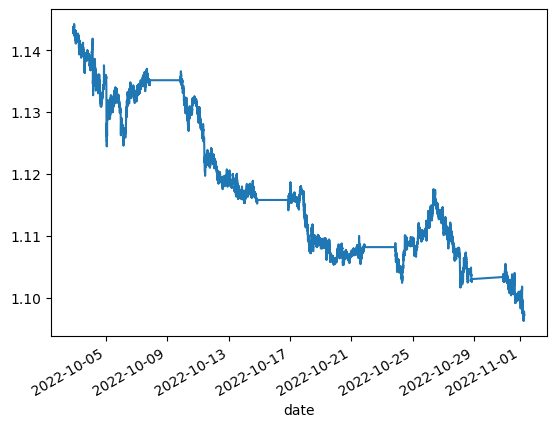

In [4]:
df1.close.plot()

## 3) BackTesting

### Settings

In [16]:
provider = 'darwinex'
inicial_cash = 50000 # initial capital for the portfolio
start_date = dt.datetime(2022,1,1) # Start date for backtesting


strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'AUDNZD',
             'short_period': 10,
             'long_period': 500,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0}}

strategy2 = {'id': 2, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'EURJPY',
             'short_period': 10,
             'long_period': 500,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0}}



conf_portfolio = {'Name': 'PortfolioForex1',
                  'Data_Sources': 
                  [{'tickers': ['AUDNZD','EURJPY'],
                   'event_type': 'bar',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_historical_1min'}],
                   'Strategies': 
                    [strategy1, strategy2]}

In [17]:
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type='financial',
                                  send_orders_to_broker=False, start_date=start_date,
                                  inicial_cash=inicial_cash)
portfolio.run_simulation() # backtest 

info_port = portfolio.get_saved_values_strategy() # read change of positions

Loading AUDNZD from 2022-10-01 00:00:00
Loading EURJPY from 2022-10-01 00:00:00
Loading AUDNZD from 2022-11-01 00:00:00
Loading EURJPY from 2022-11-01 00:00:00


## Statistics

Plots and statistics of the Strategies and the Portfolio.

<AxesSubplot:xlabel='datetime'>

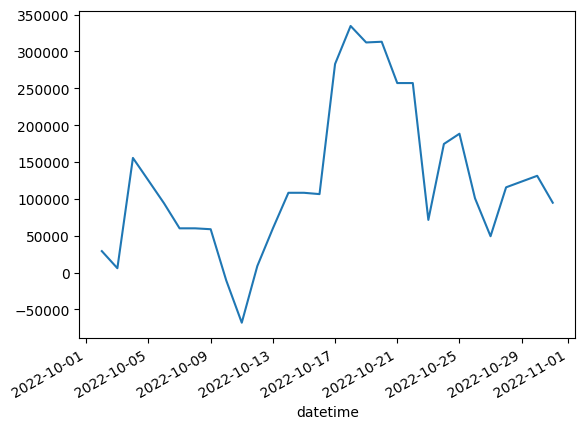

In [18]:
equities =portfolio.equity_handler.get_equities()
equity_portfolio = equities['equity_portfolio']['equity']
metrics =return_series.from_nav(equity_portfolio)
equity_portfolio.plot()

In [8]:
metrics.summary()

Performance number
Return                                       1.31873
# Events                                          29
# Events per year                                352
Annua Return                                 15.9056
Annua Volatility                             26.5165
Annua Sharpe Ratio (r_f = 0)                0.599838
Max Drawdown                                 5.39715
Max % return                                  3.4904
Min % return                                -3.56413
MTD                                          1.31873
YTD                                          1.31873
Current Nav                                    50447
Max Nav                                      52844.4
Current Drawdown                             4.53681
Calmar Ratio (3Y)                            2.94704
# Positive Events                                 15
# Negative Events                                 14
Value at Risk (alpha = 95)                   1.70357
Conditional Value at Risk (

In [30]:
equities['equities_by_day']

[            equity  quantity     price  ticker   diff  id_strategy
 datetime                                                          
 2022-10-02  -1.110      0.00  1.142320  AUDNZD  0.000            1
 2022-10-03  -1.110      0.00  1.136875  AUDNZD  0.000            1
 2022-10-04  -4.505      0.01  1.135325  AUDNZD -3.395            1
 2022-10-05 -13.975      0.00  1.127410  AUDNZD -9.470            1
 2022-10-06 -11.235      0.01  1.133170  AUDNZD  2.740            1
 2022-10-07 -11.985      0.01  1.135150  AUDNZD -0.750            1
 2022-10-08 -11.985      0.01  1.135150  AUDNZD  0.000            1
 2022-10-09 -13.160      0.00  1.134395  AUDNZD -1.175            1
 2022-10-10 -14.130      0.00  1.129700  AUDNZD -0.970            1
 2022-10-11 -14.130      0.00  1.122150  AUDNZD  0.000            1
 2022-10-12 -14.130      0.00  1.118760  AUDNZD  0.000            1
 2022-10-13 -17.095      0.00  1.117050  AUDNZD -2.965            1
 2022-10-14 -20.385      0.00  1.115815  AUDNZD 